In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [2]:
get_ipython().system('pip install db-dtypes')
get_ipython().system('pip install xgboost')
get_ipython().system('pip install impyute')
get_ipython().system('pip install prophet')
get_ipython().system('pip install plotly')
get_ipython().system('pip install plotly-geo')

In [3]:
import datetime
import itertools
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.figure_factory

ModuleNotFoundError: No module named 'plotly'

In [4]:
import statsmodels.api as sm
import sklearn.experimental.enable_iterative_imputer
import sklearn.impute
import sklearn.ensemble
import sklearn.model_selection
import sklearn.linear_model
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [5]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

In [7]:
# load data
def query(table):
    bigquery_client = bigquery.Client(project='ironhacks-data')
    query_str = f'''
SELECT *
FROM `ironhacks-data.ironhacks_competition.{table}`
'''
    query_job = bigquery_client.query(query_str)
    data = query_job.to_dataframe()
    return data

In [8]:
def combine(u, w):
    '''
    Joins the unemployment data and the wage data on `uu_id`
    '''
    ww = w.loc[:, ['uu_id', 'average_wage']]
    d = u.join(ww.set_index('uu_id'), on='uu_id')
    return d

In [9]:
def load_raw(csv_name='0_raw.csv'):
    '''
    Loads the unemployment and wage data and does some basic cleaning
    '''
    if not os.path.isfile(csv_name):
        u = query('unemployment_data')
        w = query('wage_data')
        raw = combine(u, w)
        raw.to_csv(csv_name, index=False)
    else:
        raw = pd.read_csv(csv_name)
    raw = raw.drop(['tract', 'timeperiod'], axis=1)
    raw = raw.sort_values(by=['uu_id', 'week_number'])
    raw = raw.drop_duplicates()
    raw = raw.replace({np.nan: None})
    raw = raw.reset_index(0, drop=True)
    return raw

In [10]:
load_raw().to_dict('records')[0]

{'uu_id': '001cd9ae23064d7f0fd3cd327c873d8d',
 'week_number': 31,
 'countyfips': 18099,
 'tract_name': 'Census Tract 201.02, Marshall County, Indiana',
 'total_claims': 34,
 'edu_8th_or_less': None,
 'edu_grades_9_11': 0.0,
 'edu_hs_grad_equiv': 30.0,
 'edu_post_hs': None,
 'edu_unknown': 0.0,
 'top_category_employer1': '31-33',
 'top_category_employer2': '23',
 'top_category_employer3': '81',
 'gender_female': None,
 'gender_male': None,
 'gender_na': 0.0,
 'race_amerindian': 0.0,
 'race_asian': 0.0,
 'race_black': 0.0,
 'race_noanswer': 0.0,
 'race_hawaiiannative': 0.0,
 'race_other': 0.0,
 'race_white': 34.0,
 'average_wage': 10484.333333333334}

In [11]:
# define relevant columns based on categories 
COL_MAP = {
    'edu': ['edu_8th_or_less', 'edu_grades_9_11', 'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown'],
    'race': ['race_amerindian', 'race_asian', 'race_black', 'race_noanswer', 'race_hawaiiannative', 'race_other', 'race_white'],    
    'gender': ['gender_female', 'gender_male', 'gender_na'],
    'industry': ['top_category_employer1', 'top_category_employer2', 'top_category_employer3']        
}

In [12]:
def get_cols(names):
    l = []
    for name in names:
        if name in COL_MAP:
            l += COL_MAP[name]
        else:
            l += [name]
    return l

In [13]:
def subset(df, uu_id):        
    return df.loc[df.uu_id == df.uu_id.unique()[uu_id], :]

In [14]:
def convert_to_submission(results_csv, week_number_to_submit=40):
    r = pd.read_csv(results_csv)
    last = r.loc[r.week_number == week_number_to_submit, ['uu_id', 'predicted']]
    last.index = last.uu_id
    uuid_map = last.to_dict(orient='dict')['predicted']
    p = query('prediction_list')
    p['total_claims'] = p['uu_id'].map(uuid_map)
    p.to_csv('submission_prediction_output.csv', index=False)

In [15]:
def get_week_number_map(g, colname):
    '''
    Creates a dictionary that maps from week number to an existing value in a given `colname`
    '''
    g = g[['week_number', colname]]
    week_number_map = dict(sorted(g.values.tolist()))
    return week_number_map

In [16]:
def get_county(tract_name):
    m = re.search('Census Tract \S+, (.+) County, Indiana', tract_name)
    county = m.group(1)
    return county

In [17]:
def week_number_to_date(week_number, first_week_date='20220101'):
    '''
    Prepare a date column for ARIMA
    '''
    return pd.to_datetime(first_week_date, format='%Y%m%d') + pd.DateOffset(days=7*(week_number - 1))

In [18]:
def insert_na_week_number(g, max_week_number=37):    
    d = {}
    for colname in g.columns:
        if colname == 'week_number':
            continue
        week_number_map = get_week_number_map(g, colname)
        series = pd.Series(range(1, max_week_number+1))        
        d[colname] = series.map(week_number_map)        
        
    df = pd.DataFrame(d)
    df['week_number'] = range(1, max_week_number+1)
    df['uu_id'] = [v for v in df['uu_id'].unique() if type(v) == str][0]
    df['average_wage'] = [v for v in g['average_wage'].unique()][0]
    df['countyfips'] = [v for v in g['countyfips'].unique()][0]
    df['county'] = get_county([v for v in g['tract_name'].unique()][0])
    return df

In [19]:
def load_raw_full(csv_name='1_raw_full.csv'):
    if not os.path.isfile(csv_name):
        raw = load_raw()
        raw_full = raw.groupby('uu_id').apply(insert_na_week_number).reset_index(0, drop=True)
        raw_full['date'] = raw_full['week_number'].apply(week_number_to_date)
        raw_full = raw_full.drop(['tract_name'], axis=1)
        raw_full.to_csv(csv_name, index=False)        
    else:
        raw_full = pd.read_csv(csv_name)
    return raw_full

In [20]:
load_raw_full().to_dict('records')[0]

{'uu_id': '001cd9ae23064d7f0fd3cd327c873d8d',
 'total_claims': nan,
 'edu_8th_or_less': nan,
 'edu_grades_9_11': nan,
 'edu_hs_grad_equiv': nan,
 'edu_post_hs': nan,
 'edu_unknown': nan,
 'top_category_employer1': nan,
 'top_category_employer2': nan,
 'top_category_employer3': nan,
 'gender_female': nan,
 'gender_male': nan,
 'gender_na': nan,
 'race_amerindian': nan,
 'race_asian': nan,
 'race_black': nan,
 'race_noanswer': nan,
 'race_hawaiiannative': nan,
 'race_other': nan,
 'race_white': nan,
 'average_wage': 10484.333333333334,
 'week_number': 1,
 'date': '2022-01-01'}

In [21]:
def plot_impute(n=6):
    raw = load_raw_full()
    imp = load_imp_tot()
    fig, axs = plt.subplots(ncols=n, sharey=False, figsize=(n*3, 3))
    for i in range(n):
        rraw = subset(raw, i)
        iimp = subset(imp, i)
        ax = axs[i]
        ax.plot(rraw.week_number, rraw.total_claims, 'o', label='original')
        ax.plot(iimp.week_number, iimp.total_claims, '-', label='imputed')
        ax.set_xlim(0, 42)
    axs[-1].legend(fancybox=False)

In [22]:
def imp_tot(g):
    g['total_claims'] = g['total_claims'].interpolate(method='linear')
    g = g[g['total_claims'].notna()]
    return g

In [23]:
def load_imp_tot(csv_name='2_imp_tot.csv'):
    if not os.path.isfile(csv_name):
        d = load_raw_full()
        d = d.groupby(['uu_id']).apply(imp_tot).reset_index(0, drop=True)
        d.to_csv(csv_name, index=False)
    else:
        d = pd.read_csv(csv_name)
    return d

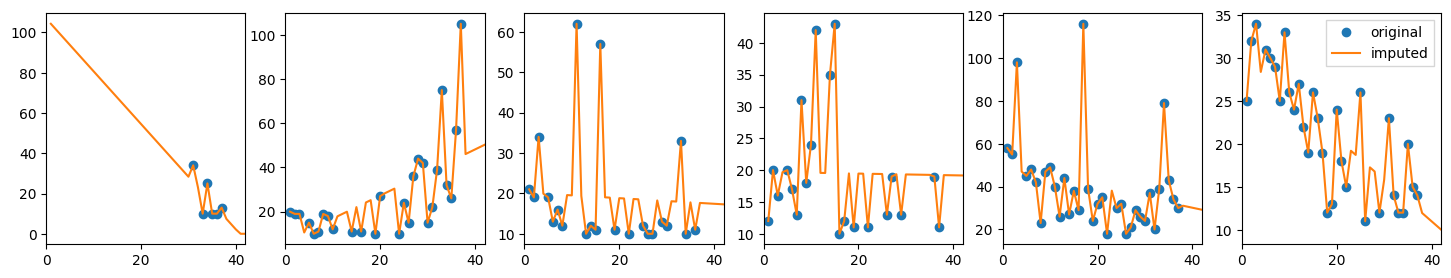

In [24]:
plot_impute()

In [25]:
def replace_na_cols(g):
    '''
    If a column only has None or zero values, replace that entire columnn with zeros
    '''
    x = g.copy()
    for col in g.columns:
        cond1 = g[col].isnull()
        cond2 = g[col] == 0
        if (cond1 | cond2).all():
            x[col] = 0        
    return x

In [26]:
def impute_iterative(df):
    '''
    Wrapper fucntion for IterativeImputer for a generic data frame. 
    Mostly, for testing. We might need need this function
    Impute data assuming there are zero columns where all the values are NA
    '''
    imputer = sklearn.impute.IterativeImputer(random_state=0, min_value=0)
    imputed_cols = imputer.fit_transform(df)
    df_imputed = pd.DataFrame(imputed_cols, columns=df.columns)
    return df_imputed

In [27]:
def iter_cat(g):
    g = replace_na_cols(g)    
    for cat in ['edu', 'race', 'gender']:
        gg = g.loc[:, COL_MAP[cat] + ['total_claims']]
        yield cat, gg

In [28]:
def print_impute_cat(test_subset, impute_func):
    for cat, gg in iter_cat(test_subset):
        line = '*'*len(cat)
        print(line)
        print(cat)
        print(line)
        print(impute_func(gg).head())

In [29]:
print_impute_cat(subset(load_imp_tot(), 6), impute_iterative)

***
edu
***
   edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  edu_post_hs  edu_unknown  total_claims
0              0.0              0.0          10.355547         21.0          0.0     17.000000
1              0.0              0.0          11.000000         21.0          0.0     25.000000
2              0.0              0.0          23.000000         21.0          0.0     32.000000
3              0.0              0.0          17.446254         21.0          0.0     24.858612
4              0.0              0.0          12.000000         21.0          0.0     20.000000
****
race
****
   race_amerindian  race_asian  race_black  race_noanswer  race_hawaiiannative  race_other  race_white  total_claims
0              0.0         0.0   12.236978            0.0                  0.0         0.0    2.225134     17.000000
1              0.0         0.0   21.000000            0.0                  0.0         0.0    1.868450     25.000000
2              0.0         0.0   27.389486          

In [30]:
def impute_rowsum(df, target_col='total_claims'):
    l = []
    for idx, row in df.iterrows():
        n_unknowns = row.isna().sum()        
        if n_unknowns == 1:
            others = row[~row.isna() & (row.index != target_col)]
            val = row[target_col] - others.sum()
            val = val if val > 0 else 0
            row[row.isna()] = val
        l.append(row)
    df = pd.DataFrame(l).reset_index(0, drop=True)
    
    l = []
    for idx, row in df.iterrows():
        n_unknowns = row.isna().sum()        
        
        weights = {}
        for col in row[row.isna()].index:
            weights[col] = df[col].mean()
        weights = {k:v/sum(weights.values()) for k, v in weights.items()}       
        
        if n_unknowns > 1:            
            others = row[~row.isna() & (row.index != target_col)]
            row[row.isna()] = row[row.isna()].index.map(weights)*(row[target_col] - others.sum())            
        l.append(row)
        
    df_imputed = pd.DataFrame(l).reset_index(0, drop=True)
    return df_imputed

In [31]:
print_impute_cat(subset(load_imp_tot(), 6), impute_rowsum)

***
edu
***
   edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  edu_post_hs  edu_unknown  total_claims
0              0.0              0.0          13.113065     3.886935          0.0     17.000000
1              0.0              0.0          11.000000    14.000000          0.0     25.000000
2              0.0              0.0          23.000000     9.000000          0.0     32.000000
3              0.0              0.0          19.174859     5.683753          0.0     24.858612
4              0.0              0.0          12.000000     8.000000          0.0     20.000000
****
race
****
   race_amerindian  race_asian  race_black  race_noanswer  race_hawaiiannative  race_other  race_white  total_claims
0              0.0         0.0   15.266990            0.0                  0.0         0.0    1.733010     17.000000
1              0.0         0.0   21.000000            0.0                  0.0         0.0    4.000000     25.000000
2              0.0         0.0   28.737864          

In [32]:
def impute_all(df):
    x = df.copy().reset_index(0, drop=True)
    for cat, gg in iter_cat(df):
        df_imputed = impute_rowsum(gg)
        df_imputed = df_imputed.drop('total_claims', axis=1)
        x[COL_MAP[cat]] = df_imputed
    return x

In [33]:
def load_clean(csv_name='3_clean.csv'):    
    if not os.path.isfile(csv_name):
        imp_tot = load_imp_tot()
        imp = imp_tot.groupby('uu_id').apply(impute_all).reset_index(0, drop=True)
        imp['date'] = imp['week_number'].apply(week_number_to_date)
        imp.to_csv(csv_name, index=False)
    else:
        imp = pd.read_csv(csv_name)
    
    return imp

In [34]:
load_clean().to_dict('records')[0]

{'uu_id': '001cd9ae23064d7f0fd3cd327c873d8d',
 'total_claims': 104.32359001448832,
 'edu_8th_or_less': 0.0,
 'edu_grades_9_11': 0.0,
 'edu_hs_grad_equiv': 104.32359001448832,
 'edu_post_hs': 0.0,
 'edu_unknown': 0.0,
 'top_category_employer1': nan,
 'top_category_employer2': nan,
 'top_category_employer3': nan,
 'gender_female': 0.0,
 'gender_male': 104.32359001448832,
 'gender_na': 0.0,
 'race_amerindian': 0.0,
 'race_asian': 0.0,
 'race_black': 0.0,
 'race_noanswer': 0.0,
 'race_hawaiiannative': 0.0,
 'race_other': 0.0,
 'race_white': 104.32359001448832,
 'average_wage': 10484.333333333334,
 'week_number': 1,
 'date': '2022-01-01'}

In [35]:
def impute_logistic(g, ycol):
    g = g[[ycol, 'week_number', 'total_claims']]
    xcols = ['week_number', 'total_claims']
    ycols = [ycol]
    
    mask_train = ~g[ycol].isnull()
    x_train, x_test = g.loc[mask_train, xcols], g.loc[~mask_train, xcols]
    y_train, y_test = g.loc[mask_train, ycols], g.loc[~mask_train, ycols]
    
    if y_train.shape[0] == 0:
        g[ycol] = None
        return g[ycol]
    
    classes = y_train[ycol].unique()
    if len(classes) == 1:
        yhat = [classes[0]]
    else:
        model = sklearn.linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000).fit(x_train, y_train.values.ravel())
        yhat = model.predict(x_test)
    g.loc[~mask_train, ycols] = yhat
    return g[ycol]

In [36]:
def impute_industry(g, max_week_number=37):
    g = g.loc[g.week_number <= max_week_number, :]
    x = g.copy()
    for colname in COL_MAP['industry']:
        x[colname] = impute_logistic(g, colname)
    return x

In [37]:
def load_imp_industry(csv_name='4_imp_industry.csv'):
    if not os.path.isfile(csv_name):
        d = load_clean()
        d = d.groupby('uu_id').apply(impute_industry).reset_index(0, drop=True)
        d.to_csv(csv_name, index=False)
    else:
        d = pd.read_csv(csv_name)
    return d

In [38]:
load_imp_industry().isna().sum()

uu_id                     0
total_claims              0
edu_8th_or_less           0
edu_grades_9_11           0
edu_hs_grad_equiv         0
edu_post_hs               0
edu_unknown               0
top_category_employer1    0
top_category_employer2    0
top_category_employer3    0
gender_female             0
gender_male               0
gender_na                 0
race_amerindian           0
race_asian                0
race_black                0
race_noanswer             0
race_hawaiiannative       0
race_other                0
race_white                0
average_wage              0
week_number               0
date                      0
dtype: int64

In [39]:
def feature_engineer(d):
    d['gender_male_ratio'] = d['gender_male'] / d['total_claims']
    d['edu_post_hs_ratio'] = d['edu_post_hs'] / d['total_claims']
    d['race_white_ratio'] = d['race_white'] / d['total_claims']
    d['race_black_ratio'] = d['race_black'] / d['total_claims']
    d = d.drop(get_cols(['gender', 'edu', 'race']), axis=1)
    return d

In [40]:
def load_featured(csv_name='5_featured.csv'):
    if not os.path.isfile(csv_name):
        d = load_imp_industry()
        d = feature_engineer(d)
    else:
        d = pd.read_csv(csv_name)
    return d

In [41]:
load_featured().to_dict('records')[0]

{'uu_id': '001cd9ae23064d7f0fd3cd327c873d8d',
 'total_claims': 104.32359001448832,
 'top_category_employer1': '31-33',
 'top_category_employer2': '23',
 'top_category_employer3': '81',
 'average_wage': 10484.333333333334,
 'week_number': 1,
 'date': '2022-01-01',
 'gender_male_ratio': 1.0,
 'edu_post_hs_ratio': 0.0,
 'race_white_ratio': 1.0,
 'race_black_ratio': 0.0}

In [42]:
def get_tot_by_county(d):
    l = []
    for (county, week_number), g in d.groupby(['county', 'week_number']):        
        l.append({
            'county': county,
            'fips': g.countyfips.values[0],
            'week_number': week_number,
            'total_claims': g.total_claims.mean()
        })
    c = pd.DataFrame(l)
    return c

In [43]:
c = get_tot_by_county(load_featured())
c = c.loc[c.week_number == 20, :]
c.head()

KeyError: 'county'

In [44]:
values = c.total_claims
endpts = list(np.mgrid[min(values):max(values):4j])
colorscale = ["#030512","#1d1d3b","#323268","#3d4b94","#3e6ab0",
              "#4989bc","#60a7c7","#85c5d3","#b7e0e4","#eafcfd"]
# fig = plotly.figure_factory.create_choropleth(
#     fips=c.fips, values=values, scope=['Indiana'], show_state_data=True,
#     colorscale=colorscale, binning_endpoints=endpts, round_legend_values=True,
#     plot_bgcolor='rgb(229,229,229)',
#     paper_bgcolor='rgb(229,229,229)',
#     legend_title='Average Total Claims by County',
#     county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
#     exponent_format=True,
# )

NameError: name 'c' is not defined

In [45]:
values = c.total_claims
endpts = list(np.mgrid[min(values):max(values):4j])
colorscale = ["#030512","#1d1d3b","#323268","#3d4b94","#3e6ab0",
              "#4989bc","#60a7c7","#85c5d3","#b7e0e4","#eafcfd"]
fig = plotly.figure_factory.create_choropleth(
    fips=c.fips, values=values, scope=['Indiana'], show_state_data=True,
    colorscale=colorscale, binning_endpoints=endpts, round_legend_values=True,
    plot_bgcolor='rgb(229,229,229)',
    paper_bgcolor='rgb(229,229,229)',
    legend_title='Average Total Claims by County',
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
    exponent_format=True,
)

NameError: name 'c' is not defined

In [46]:
get_ipython().system('pip install db-dtypes')
get_ipython().system('pip install xgboost')
get_ipython().system('pip install impyute')
get_ipython().system('pip install prophet')
get_ipython().system('pip install plotly')
get_ipython().system('pip install plotly-geo')
get_ipython().system('pip install geopandas')
get_ipython().system('pip install pyshp')
get_ipython().system('pip install shapely')

     |████████████████████████████▏   | 40 kB 2.2 MB/s eta 0:00:01

     |████████████████████████████████| 46 kB 2.3 MB/s 
